In [1]:
#imports
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [3]:
# Transforms: normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

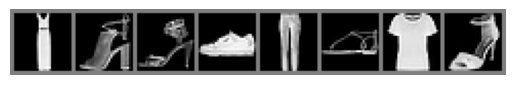

Labels: Dress | Sandal | Sandal | Sneaker | Trouser | Sandal | T-shirt/top | Sandal


In [6]:
# Class names mapping visualise
classes = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Helper to unnormalize and show images
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', ' | '.join(f'{classes[labels[j]]}' for j in range(8)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# LeNet-style CNN for grayscale FashionMNIST
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # (1, 28, 28) -> (32, 28, 28)
        self.pool = nn.MaxPool2d(2, 2)                            # -> (32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # -> (64, 14, 14)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 64 * 7 * 7)            # Flatten
        x = F.relu(self.fc1(x))               # FC1 + ReLU
        x = self.fc2(x)                       # FC2 (no activation here)
        return x


In [9]:
import torch.optim as optim

# Instantiate model, loss, optimizer
model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:  # print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0


In [10]:
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc


In [11]:
for epoch in range(5):  # You can increase later
    train(model, trainloader, optimizer, criterion, epoch)
    test(model, testloader)

# Save final model
torch.save(model.state_dict(), 'fashion_cnn.pth')


[1, 100] loss: 0.855
[1, 200] loss: 0.526
[1, 200] loss: 0.526
[1, 300] loss: 0.467
[1, 300] loss: 0.467
[1, 400] loss: 0.426
[1, 400] loss: 0.426
[1, 500] loss: 0.389
[1, 500] loss: 0.389
[1, 600] loss: 0.387
[1, 600] loss: 0.387
[1, 700] loss: 0.366
[1, 700] loss: 0.366
[1, 800] loss: 0.344
[1, 800] loss: 0.344
[1, 900] loss: 0.344
[1, 900] loss: 0.344
Test Accuracy: 87.83%
Test Accuracy: 87.83%
[2, 100] loss: 0.308
[2, 100] loss: 0.308
[2, 200] loss: 0.304
[2, 200] loss: 0.304
[2, 300] loss: 0.303
[2, 300] loss: 0.303
[2, 400] loss: 0.287
[2, 400] loss: 0.287
[2, 500] loss: 0.273
[2, 500] loss: 0.273
[2, 600] loss: 0.295
[2, 600] loss: 0.295
[2, 700] loss: 0.282
[2, 700] loss: 0.282
[2, 800] loss: 0.267
[2, 800] loss: 0.267
[2, 900] loss: 0.284
[2, 900] loss: 0.284
Test Accuracy: 89.51%
Test Accuracy: 89.51%
[3, 100] loss: 0.254
[3, 100] loss: 0.254
[3, 200] loss: 0.241
[3, 200] loss: 0.241
[3, 300] loss: 0.250
[3, 300] loss: 0.250
[3, 400] loss: 0.240
[3, 400] loss: 0.240
[3, 500] 

In [1]:
from gradcam import GradCAM
import matplotlib.pyplot as plt

# Load model again and switch to eval
model = FashionCNN().to(device)
model.load_state_dict(torch.load("fashion_cnn.pth"))
model.eval()

# Pick one test image
images, labels = next(iter(testloader))
input_img = images[0].unsqueeze(0).to(device)
label = labels[0].item()

# Create GradCAM object targeting last conv layer
cam = GradCAM(model, target_layer=model.conv2)
heatmap = cam.generate(input_img)

# Unnormalize and convert image
img = input_img.squeeze().cpu().numpy()
img = (img * 0.5) + 0.5  # unnormalize

# Resize heatmap to match image size
heatmap_resized = cv2.resize(heatmap, (28, 28))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = 0.5 * heatmap_colored[..., ::-1] / 255.0 + 0.5 * np.stack([img]*3, axis=-1)

# Show overlay
plt.imshow(overlay)
plt.title(f"True label: {classes[label]}")
plt.axis('off')
plt.show()


ModuleNotFoundError: No module named 'gradcam'